In [128]:
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm as log_progress
import itertools
import matplotlib.pyplot as plt

%run utility.ipynb

# Lab functions

## Normalization

In [129]:
def minmax(dataset):   
    result = {}
    for column in ds.columns[:-1]:
        result[column] = {'min': ds[column].min(axis=0), 'max': ds[column].max(axis=0)}
    return result

def normalize(dataset, minimax):
    for column in ds.columns[:-1]:
        mmc = minimax[column]
        ds[column] = ds[column].map(lambda val: (val - mmc['min']) / (mmc['max'] - mmc['min']))

## kNN

In [130]:
def compute_distances(dataset, target, distance_f):
    return sorted(
        [(distance_f(row, target), int(row[-1])) for row in dataset.values],
        key=lambda x: x[0]
    )

def knn(dataset, target, distance_f, kernel_f, window_f, classes):
    dists = compute_distances(dataset, target, distance_f)
    param = window_f(dists)
    ans = [0 for i in range(classes)]
    for dist, pcls in dists:
        ans[pcls] += kernel_f(dist, param)
    return ans.index(max(ans))

## Confusion matrix

In [131]:
def confusion(dataset, distance_f, kernel_f, window_f):
    classes = sorted(dataset['Class'].unique())
    classes_cnt = max(classes) + 1
    matrix = {name: {n: 0 for n in classes} for name in classes}
    for idx, row in dataset.iterrows():
        true = row[-1]
        dataset_m = dataset.drop([idx])
        predict = knn(dataset_m, row, distance_f, kernel_f, window_f, classes_cnt)
        matrix[true][predict] += 1
    return matrix

## F-score

In [132]:
def f_score(matrix):
    def f(p, r):
        return 0 if p + r == 0 else 2 * p * r / (p + r)
    
    precision = {}
    recall = {}
    f_score = {}
    sum_cls = {}
    for cls in matrix:
        tp = matrix[cls][cls]
        tp_pls_fn = sum(matrix[cls].values())
        pos = sum([matrix[other_cls][cls] for other_cls in matrix])
        
        precision[cls] = 0 if pos == 0 else tp / pos
        recall[cls] = 0 if tp_pls_fn == 0 else tp / tp_pls_fn
        sum_cls[cls] = sum([matrix[cls][x] for x in matrix[cls]])

    for cls in matrix:
        f_score[cls] = f(precision[cls], recall[cls])
    
    total = sum([sum([matrix[x][y] for y in matrix[x]]) for x in matrix])
    macro = sum([
        f_score[cls] * sum_cls[cls] for cls in matrix
    ]) / total
    micro_p = sum([
        precision[cls] * sum_cls[cls] for cls in matrix
    ]) / total
    micro_r = sum([
        recall[cls] * sum_cls[cls] for cls in matrix
    ]) / total
    return f(micro_p, micro_r)

# Wine dataset specific computations

In [133]:
filename = 'wine.csv'
ds = pd.read_csv(filename)
ds.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [134]:
# reordering
clss = ds['class']
ds.drop(['class'], axis=1, inplace=True)
ds.insert(len(ds.columns), 'Class', clss.map(lambda x: x - 1))
ds.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


In [135]:
# no vectorization, no categoric columns
# normalization
normalize(ds, minmax(ds))
ds.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,Class
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,0


## Searching best parameters

In [136]:
mdists = {df: -1.0 for df in distances}
for idx, row in log_progress(list(ds.iterrows())): 
    for df in distances:
        mdists[df] = max(mdists[df], max(compute_distances(ds.drop([idx]), row, df), key=lambda x: x[0])[0])
mdists
# now i now that ~6.2 is max dist for fixed window

{<function __main__.euclidian(x, y)>: 2.018014707251278,
 <function __main__.manhattan(x, y)>: 6.282280741680245,
 <function __main__.chebyshev(x, y)>: 1.0}

In [137]:
ds.shape[0]
# now I now that 178 is max k for neighbours

178

In [138]:
max_f = -1.0
best_conf = None
confs_l = [
    distances,
    kernels,
    windows
]
confs = list(itertools.product(*confs_l))
for conf in log_progress(confs):
    df, kf, wf = conf
    if wf == window_fixed:
        ks = np.linspace(0.1, 6.2, 10)
    else:
        ks = range(0, 171, 17)
    for k in ks:
        mat = confusion(ds, df, kf, wf(k))
        f_score_mat = f_score(mat)
        if f_score_mat > max_f:
            max_f = f_score_mat
            best_conf = (df, kf, wf, k)

# Graphics

In [139]:
bdf, bkf, bwf, bwpk = best_conf
(best_conf, max_f)

((<function __main__.euclidian(x, y)>,
  <function __main__.triweight(dist, param)>,
  <function __main__.window_variable(param)>,
  85),
 0.9834175280214206)

In [140]:
f_scores = []
variable_range = range(1, 171, 1)
for k in log_progress(variable_range):
    mat = confusion(ds, bdf, bkf, bwf(k))
    f_scores.append(f_score(mat))

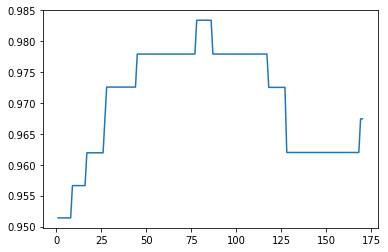

In [141]:
plt.plot(variable_range, f_scores)

In [142]:
f_scores = []
fixed_range = np.linspace(0.05, 6.5, 80)
for wp in log_progress(fixed_range):
    mat = confusion(ds, bdf, bkf, window_fixed(wp))
    f_scores.append(f_score(mat))

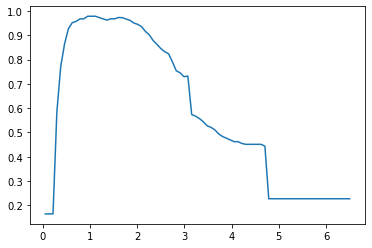

In [143]:
plt.plot(fixed_range, f_scores)

In [ ]:
# TODO more ?